# Ejercicio de programación 8:
# Sistemas de detección de anomalías y recomendación 


## Introducción

En este ejercicio, implementará el algoritmo de detección de anomalías y lo
aplicará para detectar servidores defectuosos en una red. En la segunda parte,
utilice el filtro colaborativo para crear un sistema de recomendación de películas. Antes de comenzar con el ejercicio de programación, recomendamos encarecidamente ver el video conferencias y completar las preguntas de revisión para los temas asociados.

Toda la información que necesita para resolver esta tarea está en este cuaderno, y todo el código que implementará tendrá lugar dentro del mismo. La tarea se puede enviar de inmediato al evaluador de Coursera directamente desde este cuaderno (el código y las instrucciones se incluyen a continuación).

Antes de comenzar con los ejercicios, debemos importar todas las bibliotecas necesarias para este ejercicio de programación. A lo largo del curso, usaremos [`numpy`] (http://www.numpy.org/) para todos los arreglos y operaciones de matriz, [` matplotlib`] (https://matplotlib.org/) para trazar, y [`scipy`] (https://docs.scipy.org/doc/scipy/reference/) para funciones y herramientas de cálculo científico y numérico.

In [53]:
# utilizado para manipular rutas de directorios
import os

# Cálculo científico y vectorial para python
import numpy as np

# Biblioteca de graficar
from matplotlib import pyplot
import matplotlib as mpl

# Módulo de optimización en scipy
from scipy import optimize

# se utilizará para cargar el formato de archivo de datos MATLAB mat
from scipy.io import loadmat

# biblioteca escrita para este ejercicio que proporciona funciones adicionales para el envío de tareas y otras
import utils

# # definir el objeto de presentación / calificador para este ejercicio
# grader = utils.Grader()

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## Temas


| Section | Part                                            
| :-      |:-                                                
| 1       | [Estimate Gaussian Parameters](#section1)      
| 2       | [Select Threshold](#section2)                    
| 3       | [Collaborative Filtering Cost](#section3)        
| 4       | [Collaborative Filtering Gradient](#section4)
| 5       | [Regularized Cost](#section5)                     
| 6       | [Gradient with regularization](#section6)         


## 1 Detección de anomalías

En este ejercicio, implementará un algoritmo de detección de anomalías para detectar comportamientos anómalos en los servidores. Las características miden el rendimiento (mb / s) y la latencia (ms) de respuesta de cada servidor. Mientras sus servidores estaban en funcionamiento, recopiló $ m = 307 $ ejemplos de cómo se estaban comportando y, por lo tanto, tiene un conjunto de datos sin etiquetar $\{x ^ {(1)}, \dots, x ^ {(m)}\} $ . Sospecha que la gran mayoría de estos ejemplos son ejemplos "normales" (no anómalos) de servidores que funcionan normalmente, pero también puede haber algunos ejemplos de servidores que actúan de forma anómala dentro de este conjunto de datos.

Utilizará un modelo gaussiano para detectar ejemplos anómalos en su conjunto de datos. Primero comenzará con un conjunto de datos 2D que le permitirá visualizar lo que está haciendo el algoritmo. En ese conjunto de datos, ajustará una distribución gaussiana y luego encontrará valores que tienen una probabilidad muy baja y, por lo tanto, pueden considerarse anomalías. Después de eso, aplicará el algoritmo de detección de anomalías a un conjunto de datos más grande con muchas dimensiones.

Comenzamos este ejercicio usando un pequeño conjunto de datos que es fácil de visualizar. Nuestro caso de ejemplo consta de 2 estadísticas de servidor de red en varias máquinas: la latencia y el rendimiento de cada máquina. 

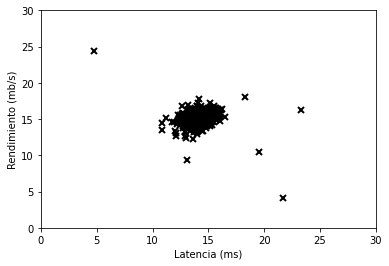

In [54]:
#   Este comando carga el dataset.
data = loadmat(os.path.join('Data', 'ex8data1.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

#  Visualizar los datos de ejemplo del dataset
pyplot.plot(X[:, 0], X[:, 1], 'bx', mew=2, mec='k', ms=6)
pyplot.axis([0, 30, 0, 30])
pyplot.xlabel('Latencia (ms)')
pyplot.ylabel('Rendimiento (mb/s)')
pass

### 1.1 Distribución gaussiana

Para realizar la detección de anomalías, primero deberá ajustar un modelo a la distribución de los datos. Dado un conjunto de entrenamiento $\{x^{(1)}, \dots, x^{(m)} \}$ (donde $x^{(i)} \in \mathbb{R}^n$ ), desea estimar la distribución gaussiana para cada una de las características $x_i$. Para cada característica $i = 1 \dots n$, necesitas encontrar los parámetros $\mu_i$ y $\sigma_i ^ 2$ que se ajusten a los datos en la dimensión $i^{th}$ $\{ x_i^{(1)}, \dots, x_i^{(m)} \}$ (la $i^{th}$ de cada ejemplo).

La distribución gaussiana está dada por

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$
Donde $\mu$ es la media y $\sigma^2$ es la varianza.

<a id="section1"></a>
### 1.2 Estimación de parámetros para un gaussiano

Puede estimar los parámetros $\left (\mu_i, \sigma_i ^ 2 \right)$, de la característica $ i ^ {th} $ usando las siguientes ecuaciones. Para estimar la media, usará:

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$

y para la varianza usará:

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

Su tarea es completar el código en la función `estimateGaussian` . Esta función toma como entrada la matriz de datos `X` y debería generar un vector de n dimensiones ` mu` que contiene la media para cada una de las características $ n $ y otro vector de n dimensiones `sigma2` que contiene las varianzas de cada una de Las características. Puede implementar esto
usando un for sobre cada característica y cada ejemplo de entrenamiento (aunque una implementación vectorizada podría ser más eficiente; siéntase libre de usar una implementación vectorizada si lo prefiere).
<a id="estimateGaussian"></a>

In [55]:
def estimateGaussian(X):
    """
    Esta función estima los parámetros de una distribución gaussiana
     utilizando un conjunto de datos proporcionado.
    
     Parámetros
     ----------
     X: array_like
         El conjunto de datos de forma (m x n) con cada n-dimensional
         punto de datos en una fila, y cada total de m puntos de datos.
    
     Devoluciones
     -------
     mu: array_like
         Un vector de forma (n,) que contiene las medias de cada dato.
    
     sigma2: array_like
         Un vector de forma (n,) que contiene las
         varianzas de cada dato.
    
     Instrucciones
     ------------
     Calcule la media de los datos y las varianzas.
     En particular, mu [i] debe contener la media de
     los datos de la característica i-ésima y sigma2 [i]
     debe contener la varianza de la característica i-ésima.
    """
    # variables útiles
    m, n = X.shape

    # Debe devolver estos valores correctamente
    mu = np.zeros(n)
    sigma2 = np.zeros(n)

    # ====================== TU CÓDIGO AQUÍ ======================
    mu = (1 / m) * np.sum(X, axis = 0)
    sigma2 = (1 / m) * np.sum((X - mu) ** 2, axis = 0)
    
    # =============================================================
    return mu, sigma2

Una vez que haya completado el código en `estimateGaussian`, en la siguiente celda visualizará los contornos de la distribución gaussiana ajustada. Debería obtener un gráfico similar a la figura siguiente.

! [] (Figures/gaussian_fit.png)

En su gráfico, puede ver que la mayoría de los ejemplos están en la región con mayor probabilidad, mientras que
los ejemplos anómalos se encuentran en las regiones con probabilidades más bajas.

Para hacer la visualización del ajuste gaussiano, primero estimamos los parámetros de nuestra distribución gaussiana calculasa, luego calculamos las probabilidades para cada uno de los puntos y  visualizamos tanto la distribución general, como dónde cae cada uno de los puntos en términos de esa distribución.

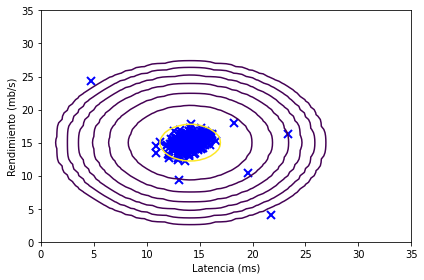

In [56]:
#  Estimar mu y sigma2
mu, sigma2 = estimateGaussian(X)

#  Devuelve la densidad de la normal multivariante en cada punto de datos (fila) 
#  de X
p = utils.multivariateGaussian(X, mu, sigma2)

#  Visualizar el ajuste
utils.visualizeFit(X,  mu, sigma2)
pyplot.xlabel('Latencia (ms)')
pyplot.ylabel('Rendimiento (mb/s)')
pyplot.tight_layout()

<a id="section2"></a>
### 1.3 Selección del umbral, $\varepsilon$

Ahora que ha estimado los parámetros gaussianos, puede investigar qué ejemplos tienen una probabilidad muy alta dada esta distribución y qué ejemplos tienen una probabilidad muy baja. Es más probable que los ejemplos de baja probabilidad sean las anomalías en nuestro conjunto de datos. Una forma de determinar qué ejemplos son anomalías es seleccionar un umbral basado en un conjunto de validación cruzada. En esta parte del ejercicio, implementará un algoritmo para seleccionar el umbral $\varepsilon$ usando la puntuación $F_1$ en un conjunto de validación cruzada.

Ahora debe completar el código para la función `selectThreshold`. Para esto, usaremos un conjunto de validación cruzada $\{(x_ {cv} ^ {(1)}, y_ {cv} ^ {(1)}), \dots, (x_ {cv} ^ {(m_ { cv})}, y_ {cv} ^ {(m_ {cv})})\} $, donde la etiqueta $ y = 1 $ corresponde a un ejemplo anómalo y $ y = 0 $ corresponde a un ejemplo normal. Para cada ejemplo de validación cruzada, calcularemos $ p \left (x_ {cv} ^ {(i)} \right) $. El vector de todas estas probabilidades $p\left( x_{cv}^{(1)}\right), \dots, p\left( x_{cv}^{(m_{cv})}\right)$ se pasa a `selectThreshold` en el vector ` pval`. Las etiquetas correspondientes $ y_ {cv} ^ {(1)}, \dots, y_ {cv} ^ {(m_ {cv})} $ se pasan a la misma función en el vector `yval`.

La función `selectThreshold` debería devolver dos valores; el primero es el umbral seleccionado $ \varepsilon $. Si un ejemplo $ x $ tiene una probabilidad baja $ p (x) <\varepsilon $, entonces se considera una anomalía. La función también debería devolver la puntuación $ F_1 $, que le indica qué tan bien lo está haciendo para encontrar las verdaderas
anomalías dado un cierto umbral. Para muchos valores diferentes de $ \varepsilon $, calculará la puntuación de $ F_1 $, calculando cuántos ejemplos el umbral actual clasifica correcta e incorrectamente.

La puntuación de $ F_1 $ se calcula usando precision ($ prec $) y recall ($ rec $):

$$ F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}, $$

Calcula la precision y recall por:

$$ prec = \frac{tp}{tp + fp}  $$ 

$$ rec = \frac{tp}{tp + fn} $$

Donde:

- $ tp $ es el número de verdaderos positivos: el umbral definido dice que es una anomalía y nuestro algoritmo la clasificó correctamente como una anomalía.

- $ fp $ es el número de falsos positivos: el umbral definido dice que no es una anomalía, pero nuestro algoritmo la clasificó incorrectamente como una anomalía.
- $ fn $ es el número de falsos negativos: el umbral definido dice que es una anomalía, pero nuestro algoritmo lo clasificó incorrectamente como no anómalo.

En el código proporcionado `selectThreshold`, ya hay un ciclo que probará muchos valores diferentes de $ \varepsilon $ y seleccionará el mejor $ \varepsilon $ basado en la puntuación $ F_1 $. Ahora debería completar el código en `selectThreshold`. Puede implementar el cálculo de la puntuación $ F_1 $ usando un bucle for en todos los ejemplos de validación cruzada (para calcular los valores $ tp $, $ fp $, $ fn $). Debería ver un valor para `epsilon` de aproximadamente 8,99e-05.



<div class="alert alert-block alert-warning">
**Nota de implementación:** Para calcular $ tp $, $ fp $ y $ fn $, puede usar una implementación vectorizada en lugar de recorrer todos los ejemplos. Esto se puede implementar mediante la prueba de igualdad de numpy
entre un vector y un solo número. Si tiene varios valores binarios en un vector binario n-dimensional $v \in \{0, 1 \} ^ n$, puede averiguar cuántos valores en este vector son 0 usando: np.sum (v == 0). También puede
aplicar un operador lógico a dichos vectores binarios. Por ejemplo, deje que `cvPredictions` sea un vector binario de tamaño igual al tamaño del conjunto de validación cruzada, donde el elemento $i ^ {th}$ es 1 si su algoritmo considera
$ x_ {cv} ^ {(i)} $ una anomalía y 0 en caso contrario. Luego puede por ejemplo, calcular el número de falsos positivos usando: `fp = np.sum ((cvPredictions == 1) & (yval == 0))`.
</div>
<a id="selectThreshold"></a>

In [57]:
def selectThreshold(yval, pval):
    """
    Encuentre el mejor umbral (épsilon) para usar para seleccionar valores atípicos basados
    sobre los resultados de un conjunto de validación y la evidencia empírica.
    
    Parámetros
    ----------
    yval: array_like
        Las etiquetas de evidencia empírica de la forma (m,).
    
    pval: array_like
        El vector precalculado de probabilidades basado en parámetros mu y sigma2. Su tamaño también es (m,).
    
    Devoluciones
    -------
    bestEpsilon: array_like
        Un vector de forma (n,) correspondiente al valor umbral.
    
    bestF1: flotar
        El valor de la mejor puntuación F1.
    
    Instrucciones
    ------------
    Calcule la puntuación F1 para elegir un épsilon como umbral y coloque el
    valor en F1. El código al final del ciclo comparará el
    Puntaje F1 para esta elección de épsilon y lo configurará como el mejor épsilon si
    es mejor que la elección actual de épsilon.
    
    Notas
    -----
    Puede usar predicciones = (pval <epsilon) para obtener un vector binario
    de 0 y 1 de las predicciones atípicas
    """
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
   
    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        # ====================== YOUR CODE HERE =======================
        predictions = (pval < epsilon)
        tp = np.sum((predictions == yval) & (yval == 1))
        fp = np.sum((predictions == 1) & (yval == 0))
        fn = np.sum((predictions == 0) & (yval == 1))
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        F1 = 2 * prec * rec / (prec + rec)
        
        

        # =============================================================
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

Una vez que haya completado el código en `selectThreshold`, la siguiente celda ejecutará su código de detección de anomalías y rodeará las anomalías en el gráfico.

Best epsilon found using cross-validation: 9.00e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)


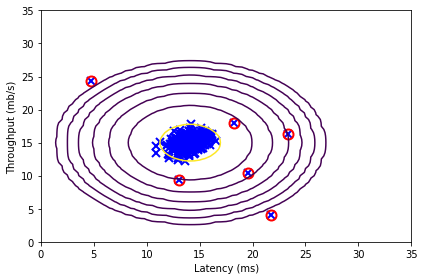

In [58]:
pval = utils.multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

#  Encuentre los valores atípicos en el conjunto de entrenamiento y trace el gráfico
outliers = p < epsilon

#  Visualizar el ajuste
utils.visualizeFit(X,  mu, sigma2)
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pyplot.tight_layout()

#  Dibuja un círculo rojo alrededor de esos valores atípicos
pyplot.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)
pass

### 1.4 Conjunto de datos de alta dimensión

La siguiente celda ejecutará el algoritmo de detección de anomalías que implementó en un conjunto de datos más realista y mucho más difícil. En este conjunto de datos, cada ejemplo se describe mediante 11 características, que capturan muchas más propiedades de sus servidores de cómputo, pero solo algunas características indican si un punto es un valor atípico. El script usará su código para estimar los parámetros gaussianos ($ \ mu_i $ y $ \ sigma_i ^ 2 $), evaluará las probabilidades para los datos de entrenamiento `X` a partir de los cuales estimó los parámetros gaussianos, y lo hará para el conjunto de validación cruzada `Xval`. Finalmente, usará `selectThreshold` para encontrar el mejor umbral $ \varepsilon $. Debería ver un valor épsilon de aproximadamente 1.38e-18 y se encontraron 117 anomalías.

In [59]:
# Carga el segundo conjunto de datos. Ahora deberías tener el
# variables X, Xval, yval en su entorno
data = loadmat(os.path.join('Data', 'ex8data2.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

# Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Datos entrenamiento 
p = utils.multivariateGaussian(X, mu, sigma2)

#  Datos Cross-validation
pval = utils.multivariateGaussian(Xval, mu, sigma2)

#  Encontrando el mejor epsilon
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set          : %f\n' % F1)
print('  (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of      0.615385)')
print('\n# Outliers found: %d' % np.sum(p < epsilon))

Best epsilon found using cross-validation: 1.38e-18
Best F1 on Cross Validation Set          : 0.615385

  (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of      0.615385)

# Outliers found: 117


## 2 sistemas de recomendación

En esta parte del ejercicio, implementará el algoritmo de aprendizaje de filtro colaborativo y lo aplicará a un conjunto de datos de clasificaciones de películas ([MovieLens 100k Dataset] (https://grouplens.org/datasets/movielens/) de GroupLens Research). Este conjunto de datos consta de calificaciones en una escala de 1 a 5. El conjunto de datos tiene $ n_u = 943 $ usuarios y $ n_m = 1682 $ películas.

En las siguientes partes de este ejercicio, implementará la función `cofiCostFunc` que calcula la función y el gradiente del objetivo del filtro colaborativo. Después de implementar la función de costo y el gradiente, usará `scipy.optimize.minimize` para aprender los parámetros para el filtro colaborativo.

### 2.1 Conjunto de datos de clasificaciones de películas

La siguiente celda cargará el conjunto de datos `ex8_movies.mat`, proporcionando las variables `Y` y` R`.
La matriz `Y` (una matriz ` num_movies` $ \times $ `num_users`) almacena las calificaciones $ y ^ {(i, j)} $ (de 1 a 5). La matriz `R` es una matriz de indicadores con valores binarios, donde $ R (i, j) = 1 $ si el usuario $ j $ calificó la película $ i $, y $ R (i, j) = 0 $ en caso contrario . El objetivo del filtro colaborativo es predecir las clasificaciones de películas para las  que los usuarios aún no han calificado, es decir, las entradas con $ R (i, j) = 0 $. Esto nos permitirá recomendar al usuario las películas con las calificaciones más altas previstas.

Para ayudarlo a comprender la matriz "Y", la siguiente celda calculará la calificación promedio de la película para la primera película (Toy Story) e imprimirá su calificación promedio.

Average rating for movie 1 (Toy Story): 3.878319 / 5


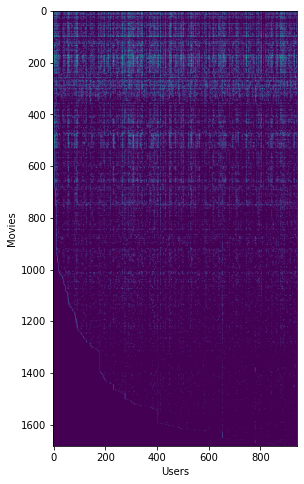

In [60]:
# Cargar los datos
data = loadmat(os.path.join('Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

# Y es una matriz de 1682x943, que contiene calificaciones (1-5) de
# 1682 películas en 943 usuarios

# R es una matriz de 1682x943, donde R (i, j) = 1
# si y solo si el usuario j calificó la película i

# A partir de la matriz, podemos calcular estadísticas como calificación promedio.
print('Average rating for movie 1 (Toy Story): %f / 5' %
      np.mean(Y[0, R[0, :] == 1]))

# Podemos "visualizar" la matriz de calificaciones trazándola con imshow
pyplot.figure(figsize=(8, 8))
pyplot.imshow(Y)
pyplot.ylabel('Movies')
pyplot.xlabel('Users')
pyplot.grid(False)

A lo largo de esta parte del ejercicio, también trabajará con las matrices, `X` y` Theta`:

$$ \text{X} = 
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{Theta} = 
\begin{bmatrix}
- \left(\theta^{(1)}\right)^T - \\
- \left(\theta^{(2)}\right)^T - \\
\vdots \\
- \left(\theta^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$

La $ i ^ {th} $ fila de `X` corresponde al vector de características $ x ^ {(i)} $ para la $ i ^ {th} $ película, y la $ j ^ {th} $ fila de` Theta` corresponde a un vector de parámetro $ \theta ^ {(j)} $, para el usuario $ j ^ {th} $. Tanto $ x ^ {(i)} $ como $ \theta ^ {(j)} $ son vectores de n dimensiones. Para los propósitos de este ejercicio, usará $ n = 100 $ y, por lo tanto, $ x ^ {(i)} \in \mathbb {R} ^ {100} $ y $ \theta ^ {(j)} \in \mathbb {R} ^ {100} $. En consecuencia, `X` es una matriz de $ n_m \times 100 $ y` Theta` es una matriz de $ n_u \times 100 $.

<a id="section3"></a>
###2.2 Algoritmo de aprendizaje de filtro colaborativo

Ahora, comenzará a implementar el algoritmo de aprendizaje de filtro colaborativo. Comenzará implementando la función de costo (sin regularización).

El algoritmo de filtro colaborativo en la configuración de recomendaciones de películas considera un conjunto de vectores de parámetros n-dimensionales $ x ^ {(1)}, \dots, x ^ {(n_m)} $ y $ \theta ^ {(1)}, \dots, \ theta ^ {(n_u)} $, donde el modelo predice la calificación de la película $ i $ por el usuario $ j $ como $ y ^ {(i, j)} = \left (\theta ^ {(j )} \right) ^ T x ^ {(i)} $. Dado un conjunto de datos que consiste en un conjunto de calificaciones producidas por algunos usuarios en algunas películas, desea aprender los vectores de parámetros $ x ^ {(1)}, \dots, x ^ {(n_m)}, \theta ^ {( 1)}, \dots, \theta ^ {(n_u)} $ que producen el mejor ajuste (minimiza el error al cuadrado).

Completará el código en `cofiCostFunc` para calcular la función de costo y el gradiente para el filtro colaborativo. Tenga en cuenta que los parámetros de la función (es decir, los valores que está tratando de aprender) son "X" y "Theta". Con el fin de utilizar un minimizador estándar como la función `minimize` de ` scipy`, la función de costo se ha configurado para desenrollar los parámetros en un solo vector llamado `params`. Anteriormente había utilizado el mismo método de desenrollado de vectores en el ejercicio de programación de redes neuronales.

#### 2.2.1 Función de costo de filtro colaborativo

La función de coste de filtrado colaborativo (sin regularización) viene dada por

$$
J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

Ahora debe modificar la función `cofiCostFunc` para devolver este costo en la variable ` J`. Tenga en cuenta que debe acumular el costo para el usuario $ j $ y la película $ i $ solo si `R [i, j] = 1`.

<div class="alert alert-block alert-warning">
**Nota de implementación **: Le recomendamos encarecidamente que utilice una implementación vectorizada para calcular $ J $, ya que luego lo llamará muchas veces el paquete de optimización de `scipy`. Como de costumbre, podría ser más fácil escribir primero una implementación no vectorizada (para asegurarse de tener la respuesta correcta) y modificarla para que se convierta en una implementación vectorizada (verificando que los pasos de vectorización no cambien la salida de su algoritmo). Para llegar a una implementación vectorizada, la siguiente sugerencia puede ser útil: Puede usar la matriz $ R $ para establecer las entradas seleccionadas en 0. Por ejemplo, `R * M` hará una multiplicación de elementos entre` M`
y `R`; dado que `R` solo tiene elementos con valores 0 o 1, esto tiene el efecto de establecer los elementos de M en 0 solo cuando el valor correspondiente en R es 0. Por lo tanto,` np.sum (R * M) `es el suma de todos los elementos de "M" para los cuales el elemento correspondiente en "R" es igual a 1.
</div>

<a id="cofiCostFunc"></a>

In [61]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Función de costo de filtro colaborativo.
    
    Parámetros
    ----------
    params: array_like
        Los parámetros que se optimizarán. Este es un
        vector dimensional de forma (num_movies x num_users, 1). Es la
        concatenación de los vectores de características X y los parámetros Theta.
    
    Y: array_like
        Una matriz de forma (num_movies x num_users) de calificaciones de películas por parte de los usuarios.
    
    R: array_like
        Una matriz (num_movies x num_users), donde R [i, j] = 1 si el
        La i-ésima película fue calificada por el j-ésimo usuario.
    
    núm_usuarios: int
        Número total de usuarios.
    
    num_movies: int
        Número total de películas.
    
    num_features: int
        Número de funciones para aprender.
    
    lambda_: float, opcional
        El coeficiente de regularización.
    
    Retorna:
    -------
    J: flotar
        El valor de la función de costo en los parámetros dados.
    
    grad: array_like
        El vector de gradiente de la función de costo en los parámetros dados.
        grad tiene una forma (num_movies x num_users, 1)
    
    Instrucciones
    ------------
    Calcule la función de costo y el gradiente para el filtro colaborativo.
    Concretamente, primero debe implementar la función de costo (sin
    regularización) y asegúrese de que coincida con nuestro costo. Después de esto,
    debe implementar el gradiente y usar la rutina checkCostFunction
    para comprobar que el gradiente es correcto. Finalmente, debes implementar la
    regularización.
    
    Notas
    -----
    - Los parámetros de entrada se resolverán en las dos matrices:
        X: (num_movies x num_features) matriz de características de la película
        Theta: (num_users x num_features) matriz de características del usuario

    - Debes configurar las siguientes variables correctamente:

        X_grad: matriz (num_movies x num_features), que contiene la
                 derivadas parciales w.r.t. a cada elemento de X
        Theta_grad: matriz (num_users x num_features), que contiene la
                     derivadas parciales w.r.t. a cada elemento de Theta

    - El gradiente devuelto será la concatenación del calculo de los
      gradientes X_grad y Theta_grad.
    """
    # Desenrrollar las matrices U y W de params
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)

    # Debes devolver los siguientes valores correctamente
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== TU CÓDIGO AQUÍ ======================
    J = (1 / 2) * np.sum(np.square((X.dot(Theta.T) - Y) * R)) + (lambda_ / 2) * np.sum(np.square(X)) + \
                                                                (lambda_ / 2) * np.sum(np.square(Theta))
    
    for i in range(R.shape[0]):
        
        idx = np.where(R[i, :] == 1)[0]
        Theta_temp = Theta[idx, :]
        Y_temp = Y[i, idx]
        X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp) + lambda_ * X[i, :]
        
    for j in range(R.shape[1]):
        
        idx = np.where(R[:, j] == 1)[0]
        X_temp = X[idx, :]
        Y_temp = Y[idx, j]
        Theta_grad[j, :] = np.dot(np.dot(X_temp, Theta[j, :]) - Y_temp, X_temp) + lambda_ * Theta[j, :]
    
    
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

Una vez que haya completado la función, la siguiente celda ejecutará su función de costo. Para ayudarlo a depurar su función de costo, hemos incluido un conjunto de pesos que entrenamos. Debería esperar ver una salida de 22,22.

In [62]:
#  Cargar los pesos pre-entrenados (X, Theta, num_users, num_movies, num_features)
data = loadmat(os.path.join('Data', 'ex8_movieParams.mat'))
X, Theta, num_users, num_movies, num_features = data['X'],\
        data['Theta'], data['num_users'], data['num_movies'], data['num_features']

#  Reducir el tamaño del conjunto de datos para que se ejecute más rápido
num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
R = R[:num_movies, 0:num_users]

#  Evaluar la función de costos
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features)
           
print('Cost at loaded parameters:  %.2f \n(this value should be about 22.22)' % J)

Cost at loaded parameters:  22.22 
(this value should be about 22.22)


<a id="section4"></a>
#### 2.2.2 Gradiente de filtro colaborativo

Ahora debería implementar el gradiente (sin regularización). Específicamente, debes completar el código en `cofiCostFunc` para devolver las variables ` X_grad` y `Theta_grad`. Tenga en cuenta que `X_grad` debe ser una matriz del mismo tamaño que ` X` y, de manera similar, `Theta_grad` es una matriz del mismo tamaño que `Theta`. Los gradientes de la función de costo vienen dados por:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(i)} $$

Tenga en cuenta que la función devuelve el gradiente para ambos conjuntos de variables desenrollándolos en un solo vector. Después de haber completado el código para calcular los gradientes, la siguiente celda ejecuta una verificación de gradiente
(disponible en `utils.checkCostFunction`) para verificar numéricamente la implementación de sus gradientes (esto es similar a la verificación numérica que utilizó en el ejercicio de redes neuronales. Si su implementación es correcta, debe encontrar que los gradientes analíticos y numéricos coinciden de cerca.

<div class="alert alert-block alert-warning">
**Nota de implementación: ** Puede obtener todo el crédito por esta asignación sin usar una implementación vectorizada, pero su código se ejecutará mucho más lentamente (una pequeña cantidad de horas), por lo que le recomendamos que intente vectorizar su implementación. Para comenzar, puede implementar el gradiente con un for sobre películas
(para calcular $\frac{\partial J}{\partial x^{(i)}_k}$) y un for sobre los usuarios (para calcular $\frac{\partial J}{\theta_k^{(j)}}$) Cuando implemente por primera vez el gradiente, puede comenzar con una versión no vectorizada, implementando otro for interno que calcula cada elemento y la suma de los mismos. Una vez que haya completado el cálculo del gradiente de esta manera, debe intentar vectorizar su implementación (vectorizar los  for internos), de modo que solo le queden dos  for (uno para recorrer películas para calcular $\frac{\partial J}{\partial x_k^{(i)}}$ para cada película, y uno para recorrer los usuarios para calcular $\frac{\partial J}{\partial \theta_k^{(j)}}$ para cada usuario).
</div>

<div class="alert alert-block alert-warning">
**Sugerencia de implementación: ** Para realizar la vectorización, es posible que le resulte útil: debería encontrar una forma de calcular todas las derivadas asociadas con $x_1 ^ {(i)}, x_2 ^ {(i)}, \dots, x_n ^ {(i)}$ (es decir, los términos derivados asociados con el vector de características $x ^ {(i)}$) al mismo tiempo. Definamos las derivadas para el vector de características de la película $ i ^ {th} $ como:

$$ \left(X_{\text{grad}} \left(i, :\right)\right)^T = 
\begin{bmatrix}
\frac{\partial J}{\partial x_1^{(i)}} \\
\frac{\partial J}{\partial x_2^{(i)}} \\
\vdots \\
\frac{\partial J}{\partial x_n^{(i)}}
\end{bmatrix} = \quad
\sum_{j:r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) \theta^{(j)}
$$

Para vectorizar la expresión anterior, puede comenzar indexando en `Theta` e ` Y` para seleccionar solo los elementos de interés (es decir, aquellos con `r [i, j] = 1`). Intuitivamente, cuando consideras las funciones de la película $ i ^ {th} $, solo debes preocuparte por los usuarios que le dieron calificaciones a la película, y esto te permite eliminar a todos los demás usuarios de `Theta` e `Y`. <br/> <br/>


Concretamente, puede establecer `idx = np.where (R [i,:] == 1) [0] ` para que sea una lista de todos los usuarios que han calificado la película $ i $. Esto te permitirá crear las matrices temporales `Theta_temp = Theta [idx,:]` y `Y_temp = Y [i, idx]` que indexan en `Theta` e` Y` para darte solo el conjunto de usuarios que calificaron la película $ i ^ {th} $. Esto le permitirá escribir las derivadas como: <br>

`X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp)`

<br><br>
Tenga en cuenta que el cálculo vectorizado anterior devuelve un vector de fila en su lugar. Después de haber vectorizado los cálculos de las derivadas con respecto a $ x ^ {(i)} $, también debe usar un método similar para vectorizar las derivadas con respecto a $ θ ^ {(j)} $.
</div>

[Click aquí para volver a la función `cofiCostFunc` y actualizarla](#cofiCostFunc). 

<font color="red"> No olvide volver a ejecutar la celda que contiene la función `cofiCostFunc` para que se actualice con su implementación del cálculo del gradiente.</font>

In [63]:
#  Verifique los gradientes ejecutando checkcostFunction
utils.checkCostFunction(cofiCostFunc)

[[ -2.1546078   -2.1546078 ]
 [ -2.83426979  -2.83426979]
 [  3.00218497   3.00218497]
 [ -6.86719119  -6.86719119]
 [ -8.74200039  -8.74200039]
 [  6.77672028   6.77672028]
 [ -4.61115903  -4.61115903]
 [  3.13034118   3.13034118]
 [ -5.19342412  -5.19342412]
 [ -5.8860626   -5.8860626 ]
 [ 12.05055374  12.05055374]
 [-15.94598089 -15.94598089]
 [ -1.31545603  -1.31545603]
 [  4.0824721    4.0824721 ]
 [ -3.16051237  -3.16051237]
 [ -3.91796392  -3.91796392]
 [  4.51681393   4.51681393]
 [ -5.47313565  -5.47313565]
 [  2.55914047   2.55914047]
 [  5.24436399   5.24436399]
 [ -0.84437619  -0.84437619]
 [  1.89565923   1.89565923]
 [ -0.97382276  -0.97382276]
 [  0.0740514    0.0740514 ]
 [  2.3708117    2.3708117 ]
 [ -0.95842979  -0.95842979]
 [  0.2126064    0.2126064 ]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1

<a id="section5"></a>
#### 2.2.3 Función de costo regularizada

La función de costo del filtro colaborativo con regularización viene dada por

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

Ahora debe agregar la regularización a sus cálculos originales de la función de costo, $ J $. Una vez que haya terminado, la siguiente celda ejecutará su función de costo regularizado, y debe esperar ver un costo de aproximadamente 31,34.

[Click aquí para volver a la función `cofiCostFunc` y actualizarla](#cofiCostFunc). (#cofiCostFunc)
<font color="red"> No olvide volver a ejecutar la celda que contiene la función `cofiCostFunc` para que se actualice con su implementación de la función de costo regularizado.</font>

In [64]:
#  Evaluar la función de costo
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features, 1.5)
           
print('Cost at loaded parameters (lambda = 1.5): %.2f' % J)
print('              (this value should be about 31.34)')

Cost at loaded parameters (lambda = 1.5): 31.34
              (this value should be about 31.34)


<a id="section6"></a>
#### 2.2.4 Gradiente regularizado

Ahora que ha implementado la función de costo regularizado, debe proceder a implementar la regularización para el gradiente. Debe agregar a su implementación en `cofiCostFunc` la forma de devolver el gradiente regularizado
sumando las contribuciones de la regularización. Tenga en cuenta que los gradientes para la función de costo regularizado vienen dados por:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(i)} + \lambda \theta_k^{(j)} $$

Esto significa que solo necesita agregar $ \lambda x ^ {(i)} $ a la variable `X_grad [i,:]` descrita anteriormente, y agregar $ \lambda \theta ^ {(j)} $ a la variable ` Theta_grad [j,:] ` variable descrita anteriormente.

[Click aquí para volver a la función `cofiCostFunc` y actualizarla](#cofiCostFunc). (#cofiCostFunc)
<font color="red"> No olvide volver a ejecutar la celda que contiene la función `cofiCostFunc` para que se actualice con su implementación de la función de costo regularizado.</font>

Una vez que haya completado el código para calcular los gradientes, la siguiente celda ejecutará otra verificación de gradiente (ʻutils.checkCostFunction`) para verificar numéricamente la implementación de sus gradientes.

In [65]:
#  Verifique los gradientes ejecutando checkCostFunction
utils.checkCostFunction(cofiCostFunc, 1.5)

[[ 2.23001752  2.23001752]
 [ 1.66895421  1.66895421]
 [ 1.97870279  1.97870279]
 [-1.29082757 -1.29082757]
 [-6.8631615  -6.8631615 ]
 [-3.27565691 -3.27565691]
 [-1.49659594 -1.49659594]
 [-0.70620729 -0.70620729]
 [ 3.31776809  3.31776809]
 [-4.91048905 -4.91048905]
 [ 2.81311214  2.81311214]
 [ 2.90408325  2.90408325]
 [-2.17136684 -2.17136684]
 [-4.45081095 -4.45081095]
 [-2.49090198 -2.49090198]
 [-3.42429244 -3.42429244]
 [ 1.04658643  1.04658643]
 [-1.60907554 -1.60907554]
 [ 1.71551977  1.71551977]
 [ 1.05429426  1.05429426]
 [-2.93798204 -2.93798204]
 [ 2.24175411  2.24175411]
 [-4.56751417 -4.56751417]
 [-4.56801374 -4.56801374]
 [-1.33232272 -1.33232272]
 [-2.43391745 -2.43391745]
 [-1.52992814 -1.52992814]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1e-9).

Relative Difference: 1.89911e-12


### 2.3 Aprendiendo recomendaciones de películas

Una vez que haya terminado de implementar la función de costo de filtro colaborativo y el gradiente, ahora puede comenzar a entrenar su algoritmo para hacer recomendaciones de películas por sí mismo. En la siguiente celda, puede ingresar sus propias preferencias de películas, de modo que más tarde, cuando se ejecute el algoritmo, pueda obtener sus propias recomendaciones de películas. Hemos completado algunos valores de acuerdo con nuestras propias preferencias, pero debe cambiar esto según sus propios gustos. La lista de todas las películas y su número en el conjunto de datos se puede encontrar en el archivo `Data / movie_idx.txt`.

In [66]:
#  Antes de entrenar el modelo de filtro colaborativo, primero
# agregue calificaciones que correspondan a un nuevo usuario que acabamos de observar. Esta
# parte del código también le permitirá poner sus propias calificaciones para el
# películas en nuestro conjunto de datos!
movieList = utils.loadMovieList()
n_m = len(movieList)

#  Initialize my ratings
my_ratings = np.zeros(n_m)

# Verifique el archivo movie_idx.txt para la identificación de cada película en nuestro conjunto de datos
# Por ejemplo, Toy Story (1995) tiene ID 1, por lo que para calificarlo con "4", puede establecer
# Tenga en cuenta que el índice aquí es ID-1, ya que comenzamos el índice desde 0.
my_ratings[0] = 4

# O suponga que no disfrutó El silencio de los corderos (1991), puede configurar
my_ratings[97] = 2

# Hemos seleccionado algunas películas que nos gustaron / no nos gustaron y las calificaciones que
# dio son los siguientes:
my_ratings[22] = 3
my_ratings[54]= 5
my_ratings[49] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

New user ratings:
-----------------
Rated 4 stars: Toy Story (1995)
Rated 3 stars: Taxi Driver (1976)
Rated 4 stars: Star Wars (1977)
Rated 5 stars: Professional, The (1994)
Rated 5 stars: Shawshank Redemption, The (1994)
Rated 3 stars: While You Were Sleeping (1995)
Rated 5 stars: Forrest Gump (1994)
Rated 2 stars: Silence of the Lambs, The (1991)
Rated 4 stars: Alien (1979)
Rated 5 stars: Die Hard 2 (1990)
Rated 5 stars: Sphere (1998)


#### 2.3.1 Recomendaciones

Una vez agregadas las calificaciones adicionales al conjunto de datos, el script
procederá a entrenar el modelo de filtro colaborativo. Esto aprenderá los
parámetros X y Theta. Para predecir la calificación de la película i para el usuario j, debe calcular (θ (j)) T x (i). La siguiente parte del script calcula las calificaciones de
todas las películas y usuarios, y muestra las películas que recomienda (Figura
4), de acuerdo con las calificaciones que se ingresaron anteriormente en el script. Tenga en cuenta que
puede obtener un conjunto diferente de predicciones debido a diferentes inicializaciones aleatorias.

In [67]:
#  Ahora, entrenará el modelo de filtro colaborativo en una calificación de película en el
# conjunto de datos de 1682 películas y 943 usuarios

#  Cargar los datos
data = loadmat(os.path.join('Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

#  Y es una matriz 1682x943, que contiene clasificaciones (1-5) de 1682 películas por
# 943 usuarios

# R es una matriz de 1682x943, donde R (i, j) = 1 si y solo si el usuario j dio un
# calificación de la película i

#  Agregue sus propias calificaciones a la matriz de datos
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalizar calificaciones
Ynorm, Ymean = utils.normalizeRatings(Y, R)

#  valores útiles
num_movies, num_users = Y.shape
num_features = 10

# Establecer parámetros iniciales (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Establecer opciones para scipy.optimize.minimize
options = {'maxiter': 100}

# Establecer regularización
lambda_ = 10
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Despliegue el theta devuelto en U y W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Se completó el aprendizaje del sistema de recomendación.')

Se completó el aprendizaje del sistema de recomendación.


Después de entrenar el modelo, ahora puede hacer recomendaciones calculando la matriz de predicciones.

In [69]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = utils.loadMovieList()

ix = np.argsort(my_predictions)[::-1]

print('Las mejores recomendaciones para ti:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicción de calificación% .1f para película % s' % (my_predictions[j], movieList[j]))

print('\nCalificaciones originales proporcionadas:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Calificado %d for %s' % (my_ratings[i], movieList[i]))

Las mejores recomendaciones para ti:
----------------------------
Predicción de calificación 5.0 para película Entertaining Angels: The Dorothy Day Story (1996)
Predicción de calificación 5.0 para película Saint of Fort Washington, The (1993)
Predicción de calificación 5.0 para película They Made Me a Criminal (1939)
Predicción de calificación 5.0 para película Marlene Dietrich: Shadow and Light (1996)
Predicción de calificación 5.0 para película Great Day in Harlem, A (1994)
Predicción de calificación 5.0 para película Someone Else's America (1995)
Predicción de calificación 5.0 para película Prefontaine (1997)
Predicción de calificación 5.0 para película Santa with Muscles (1996)
Predicción de calificación 5.0 para película Aiqing wansui (1994)
Predicción de calificación 5.0 para película Star Kid (1997)

Calificaciones originales proporcionadas:
--------------------------
Calificado 4 for Toy Story (1995)
Calificado 3 for Taxi Driver (1976)
Calificado 4 for Star Wars (1977)
Califica